In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal
from matplotlib import style
import statsmodels.api as sm
plt.style.use('ggplot')


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('C://Users//Admin//OneDrive//Desktop//HPE//data.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

In [4]:
df=data.iloc[:,0::2]

In [5]:
df_anomalies= data.iloc[:,1::2]

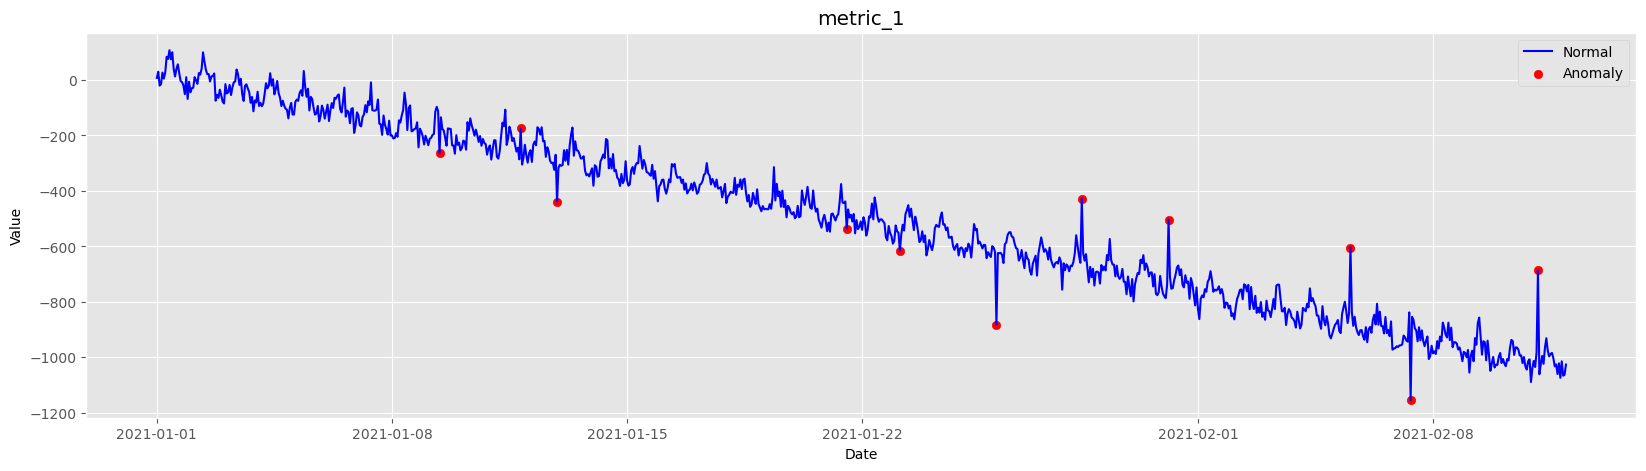

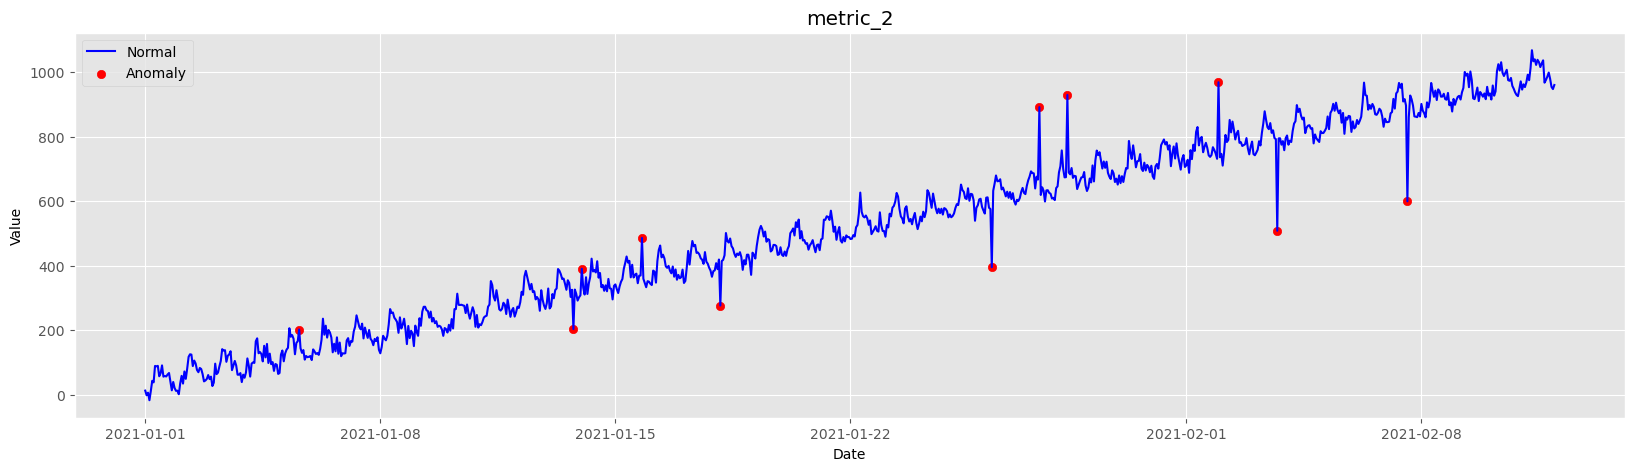

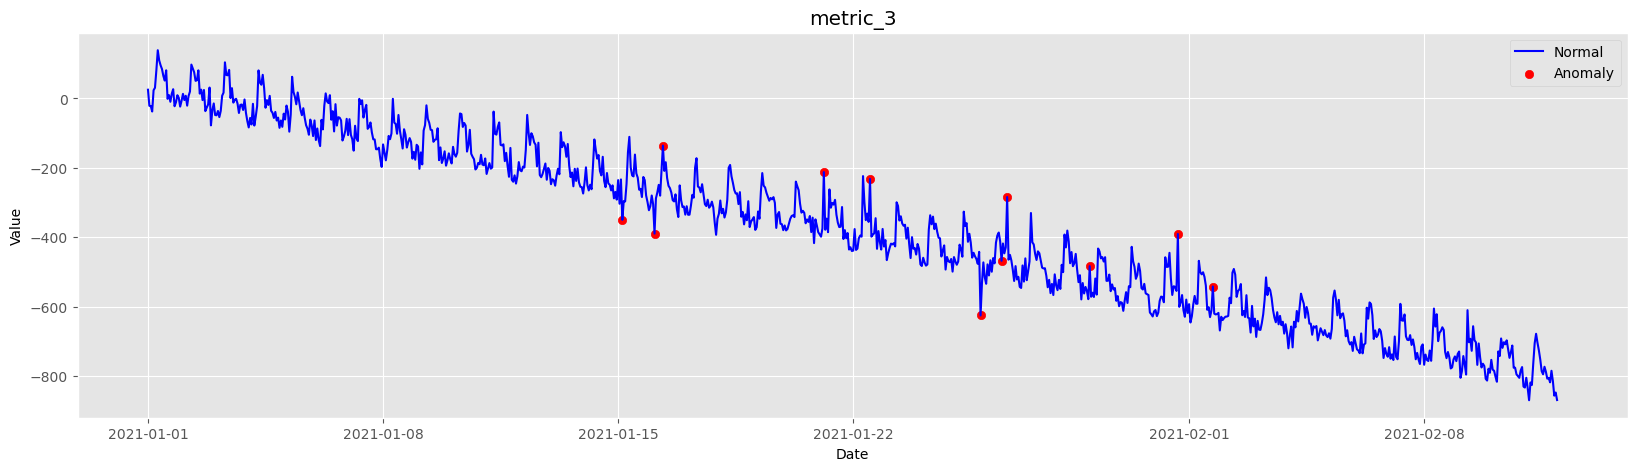

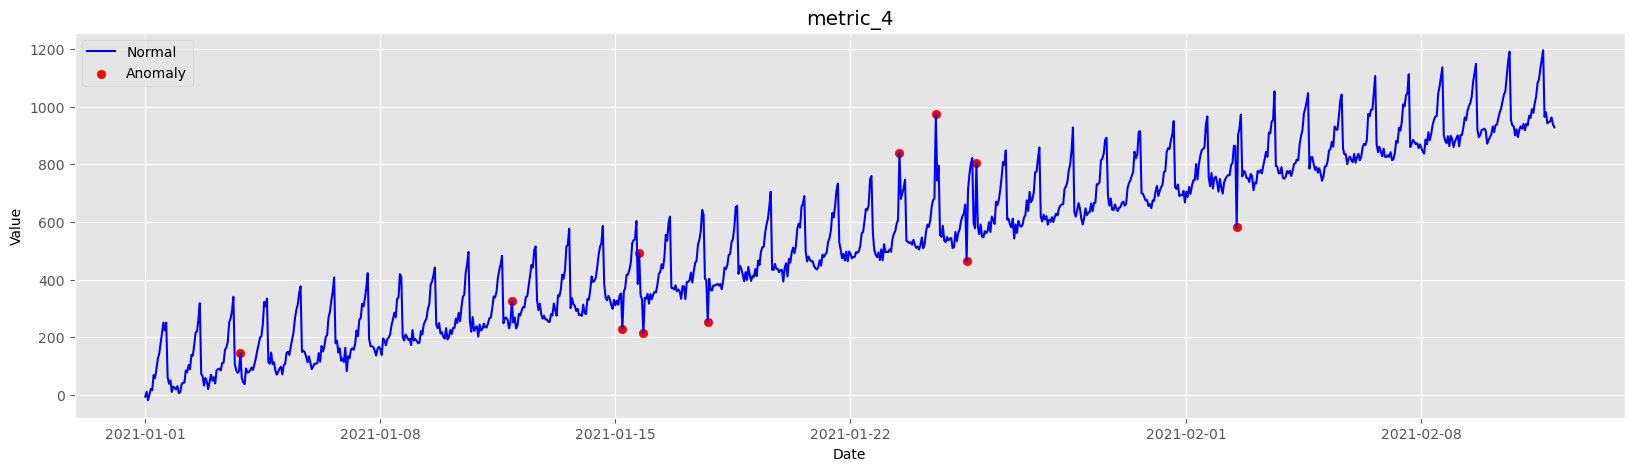

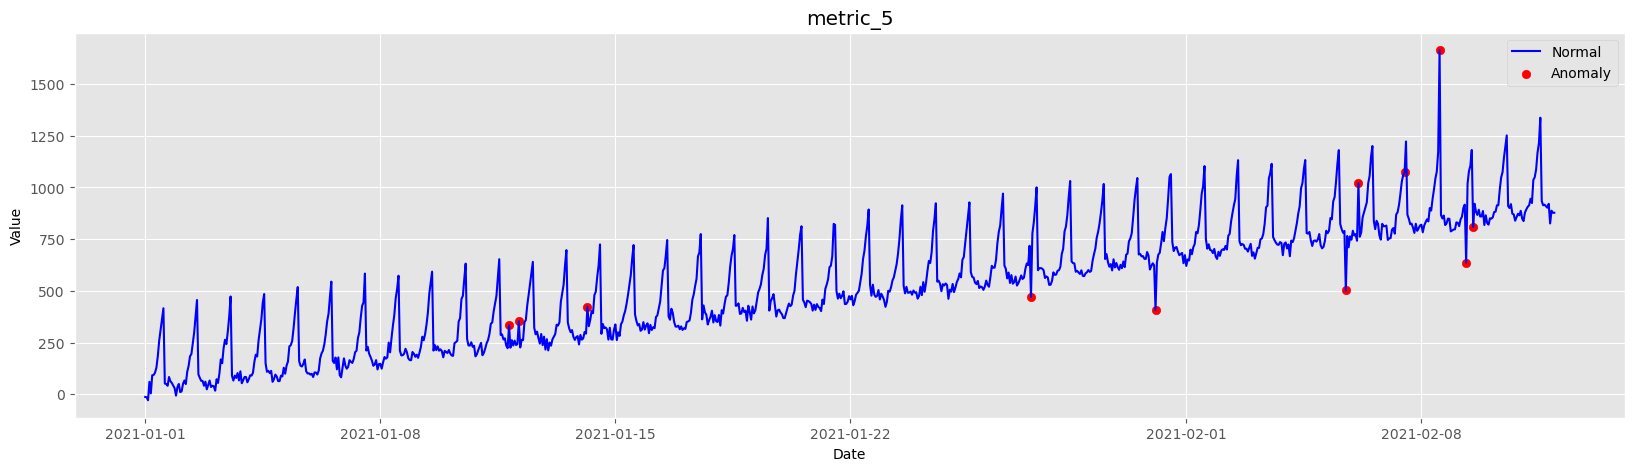

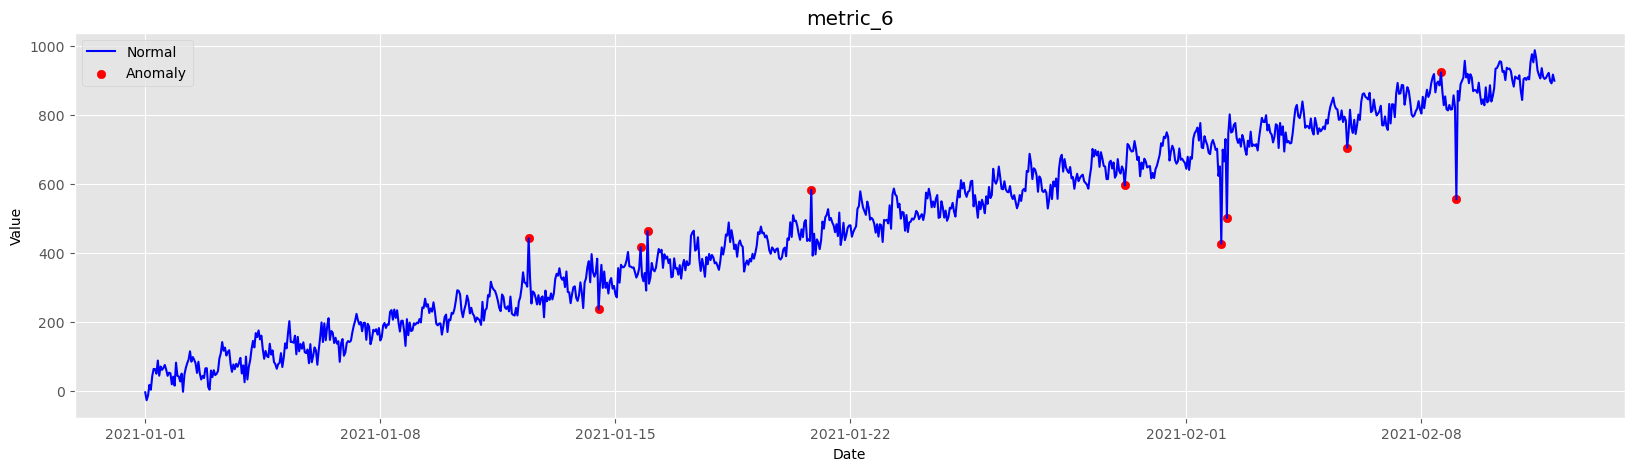

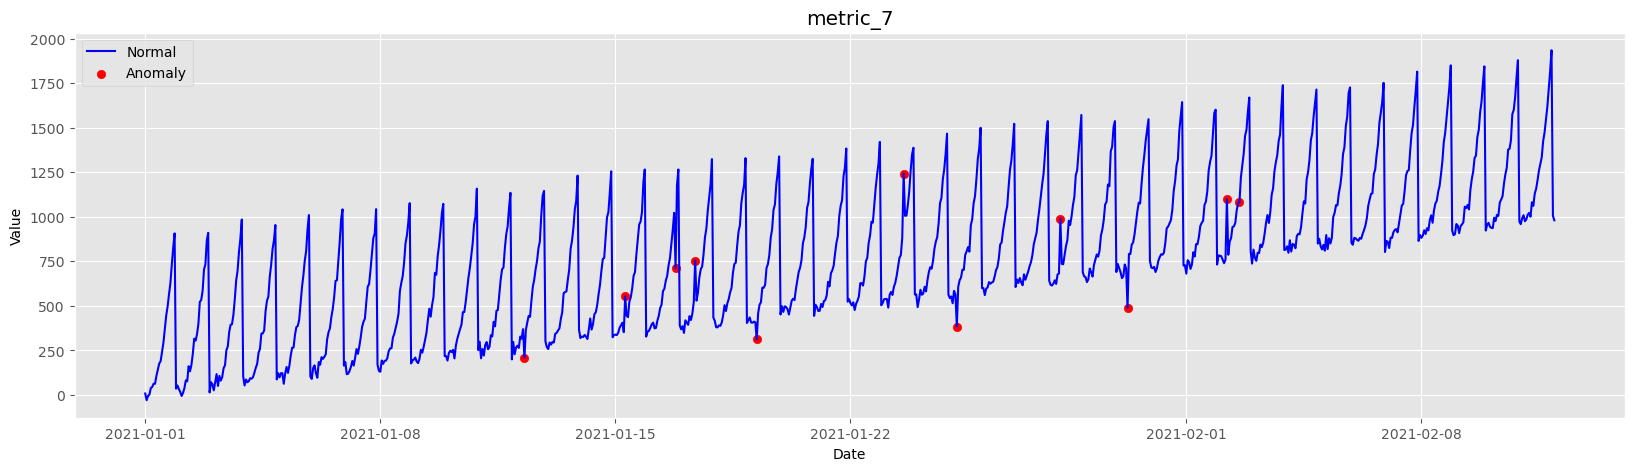

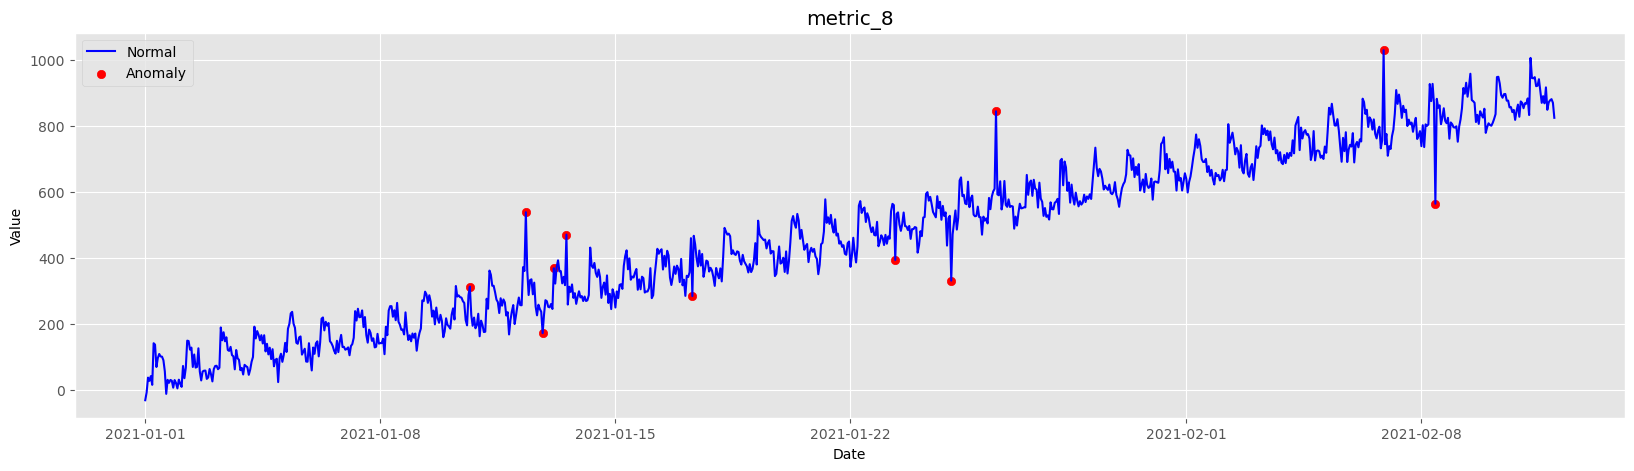

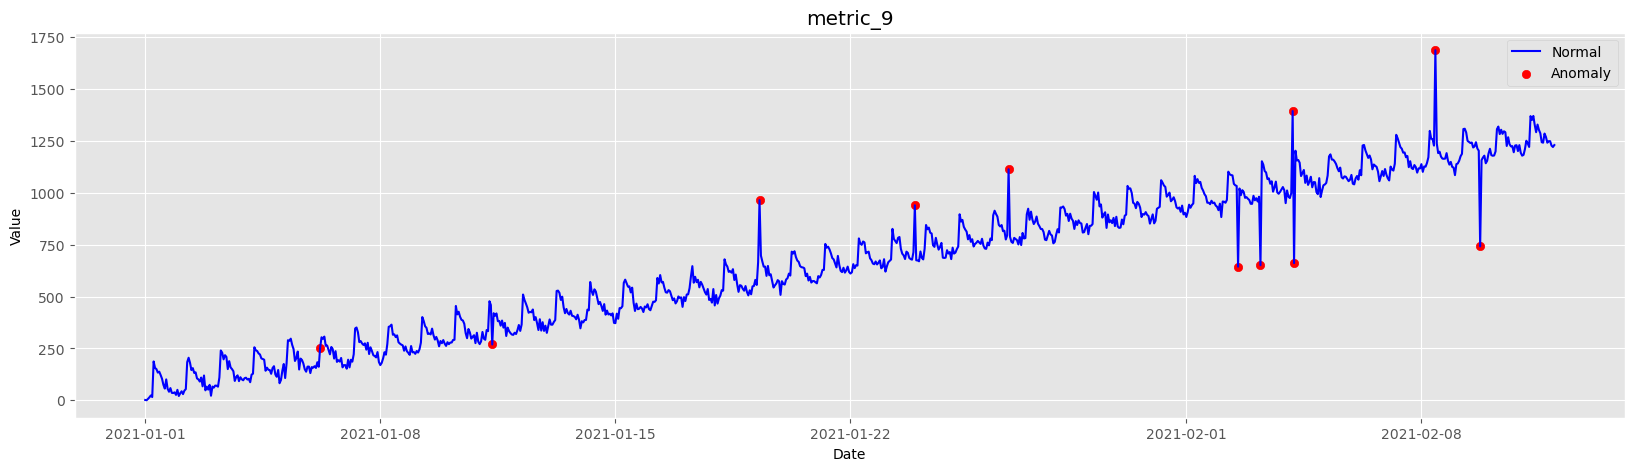

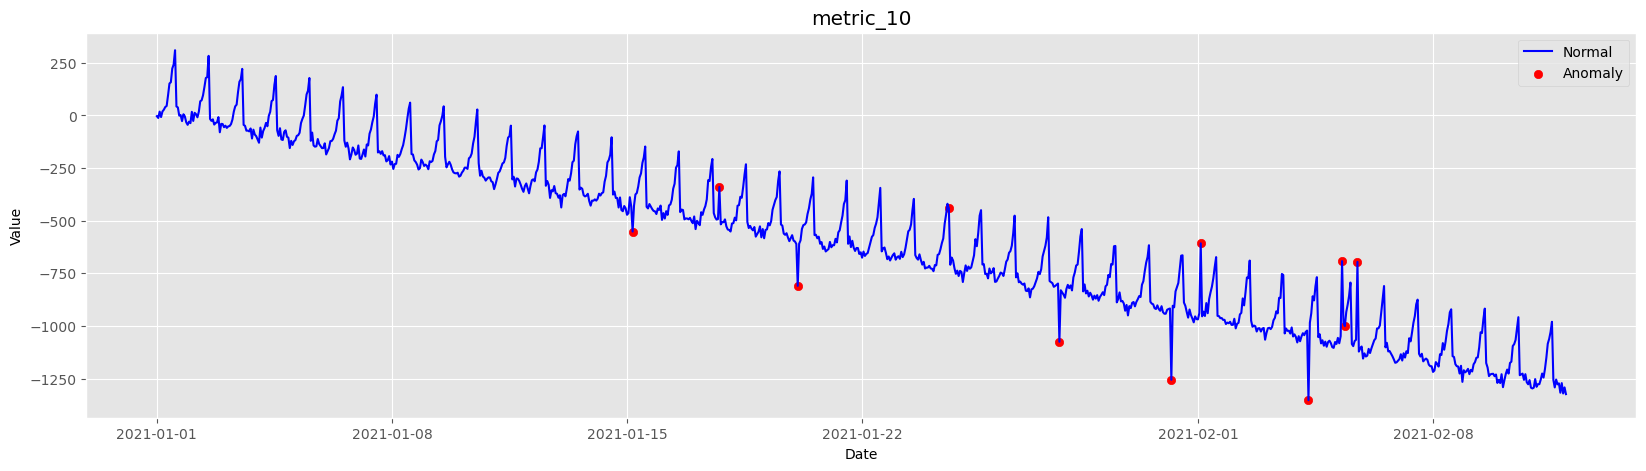

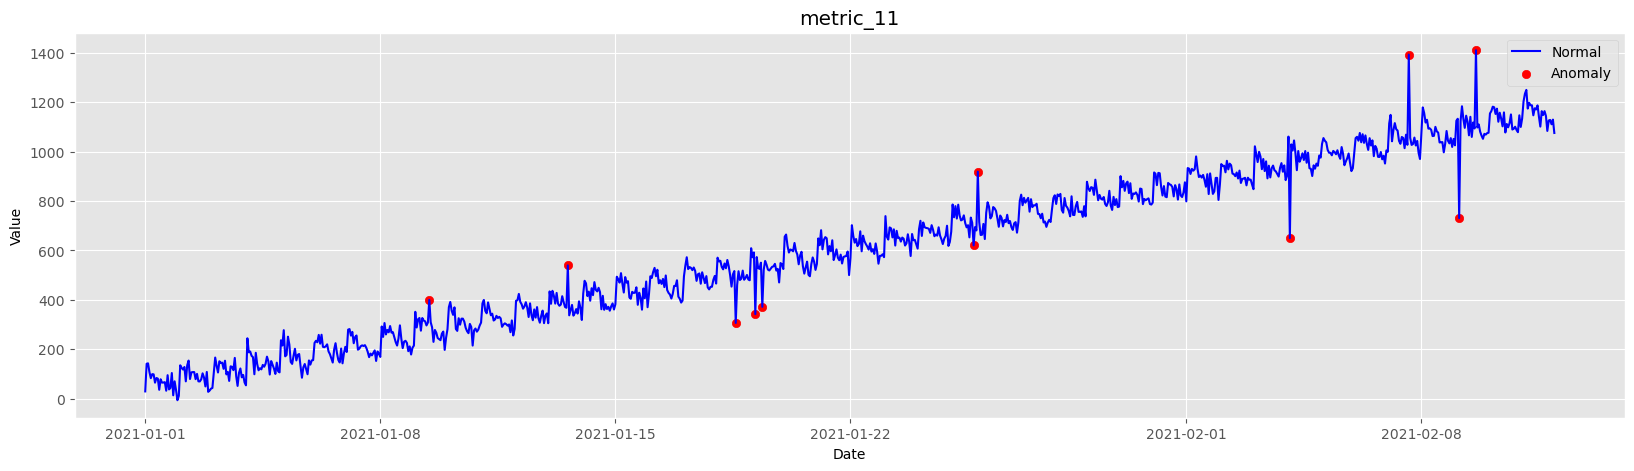

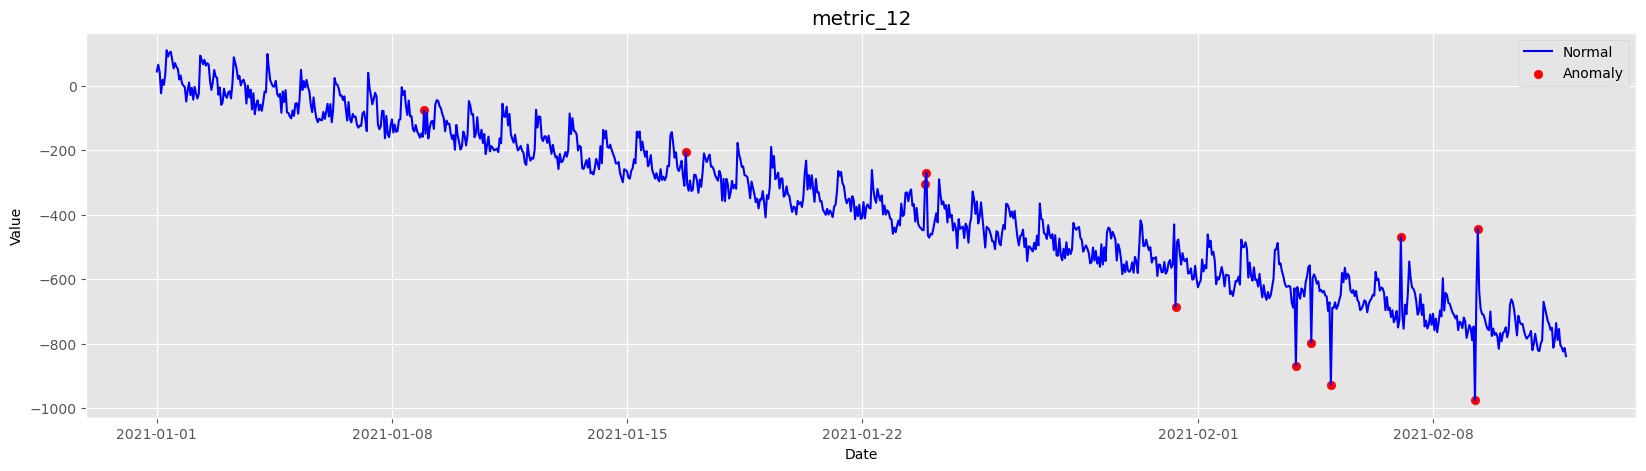

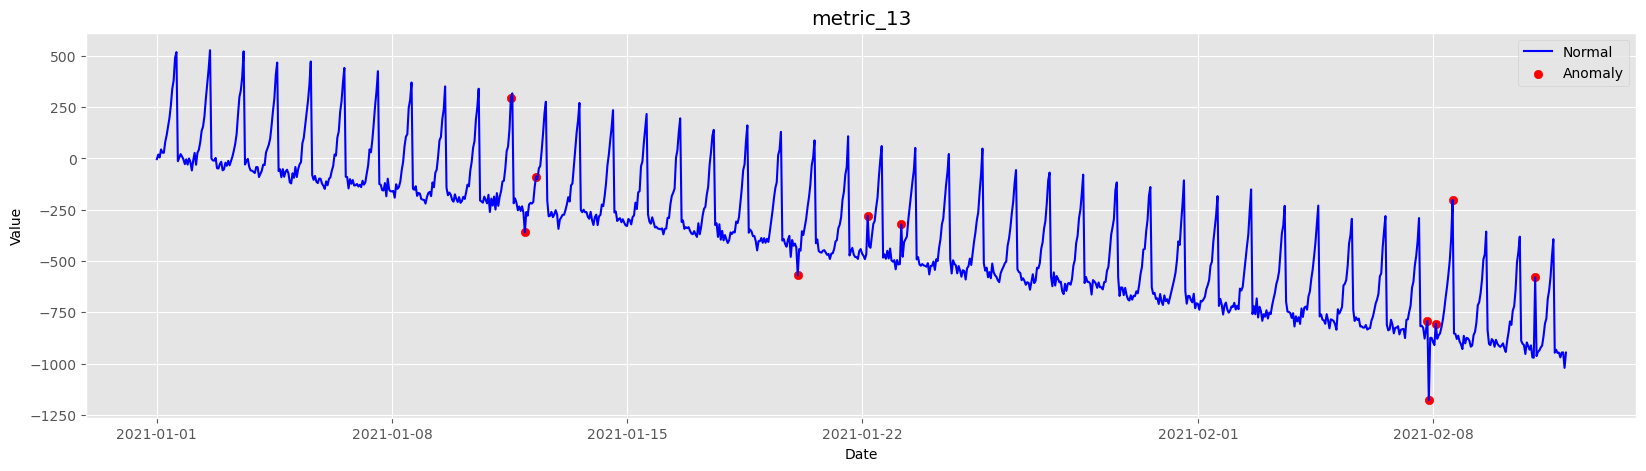

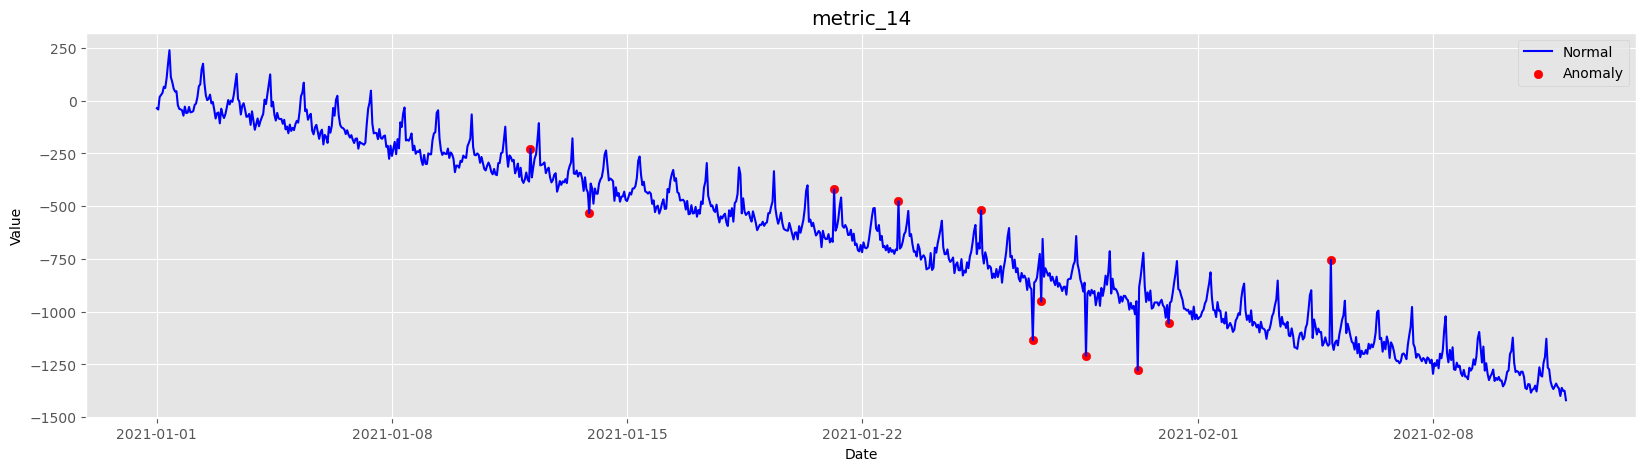

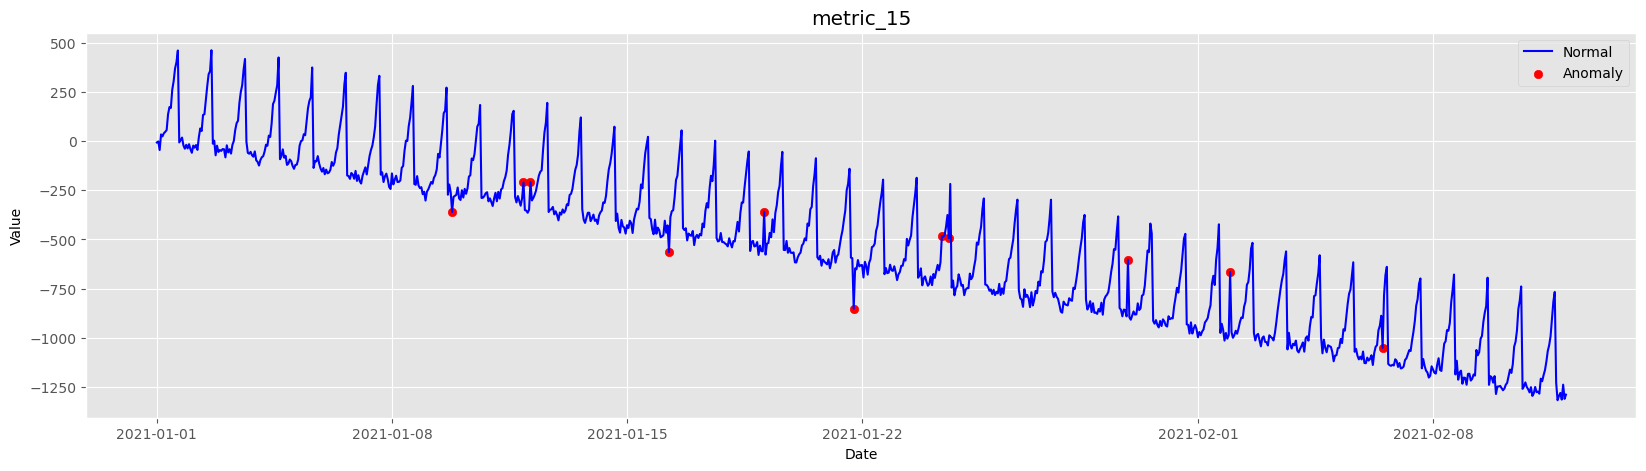

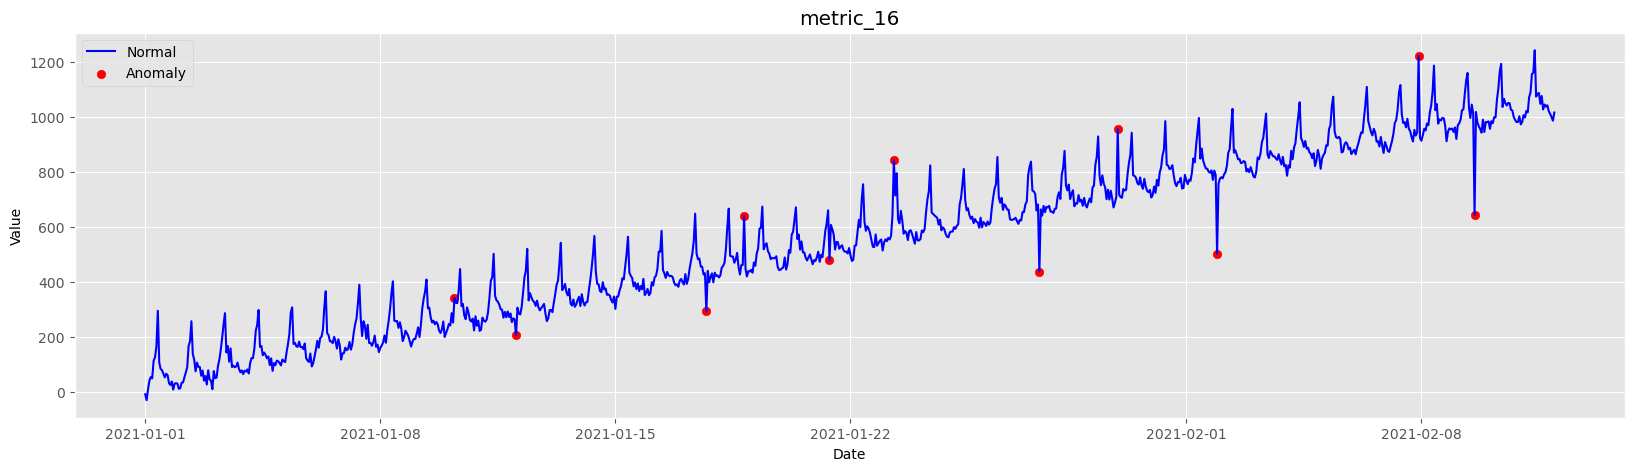

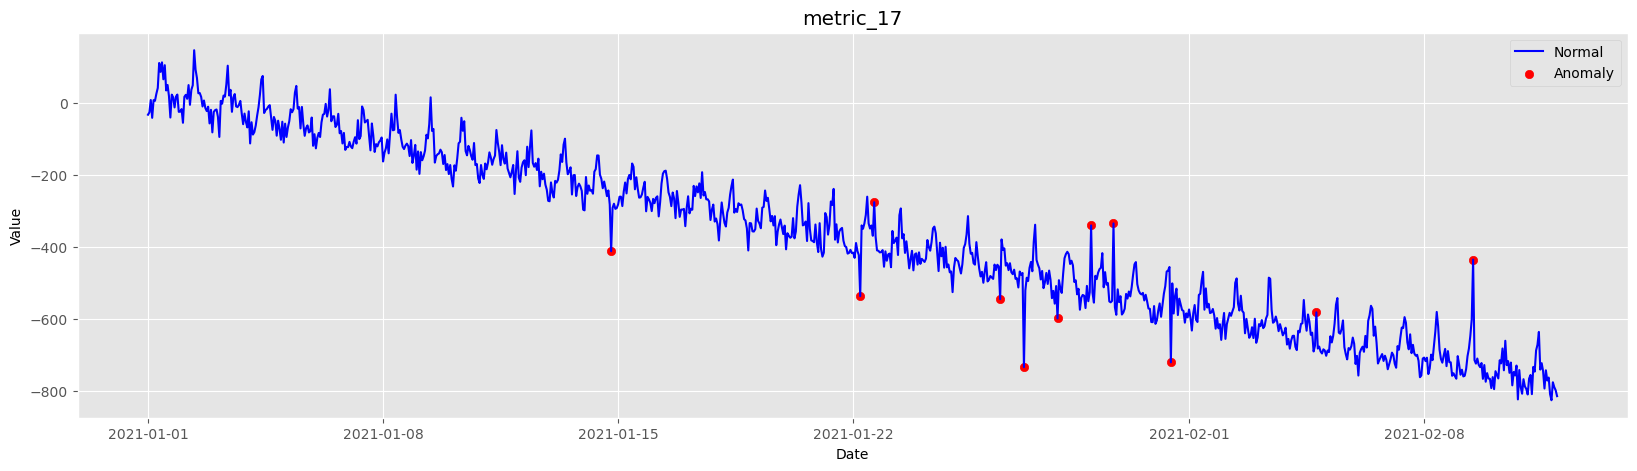

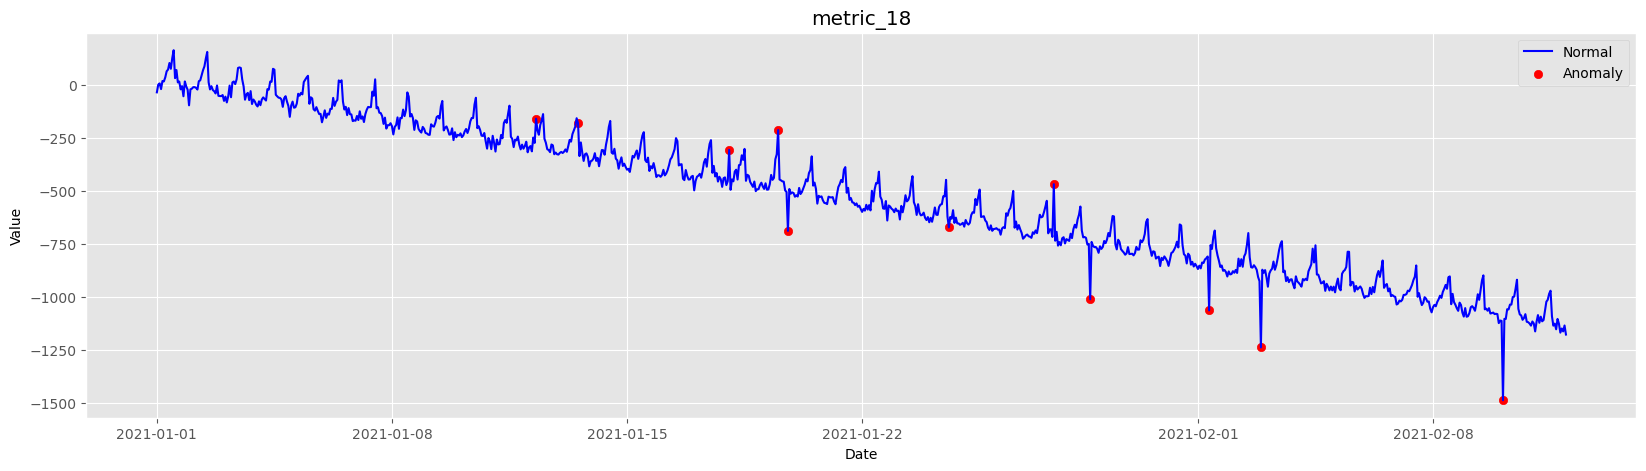

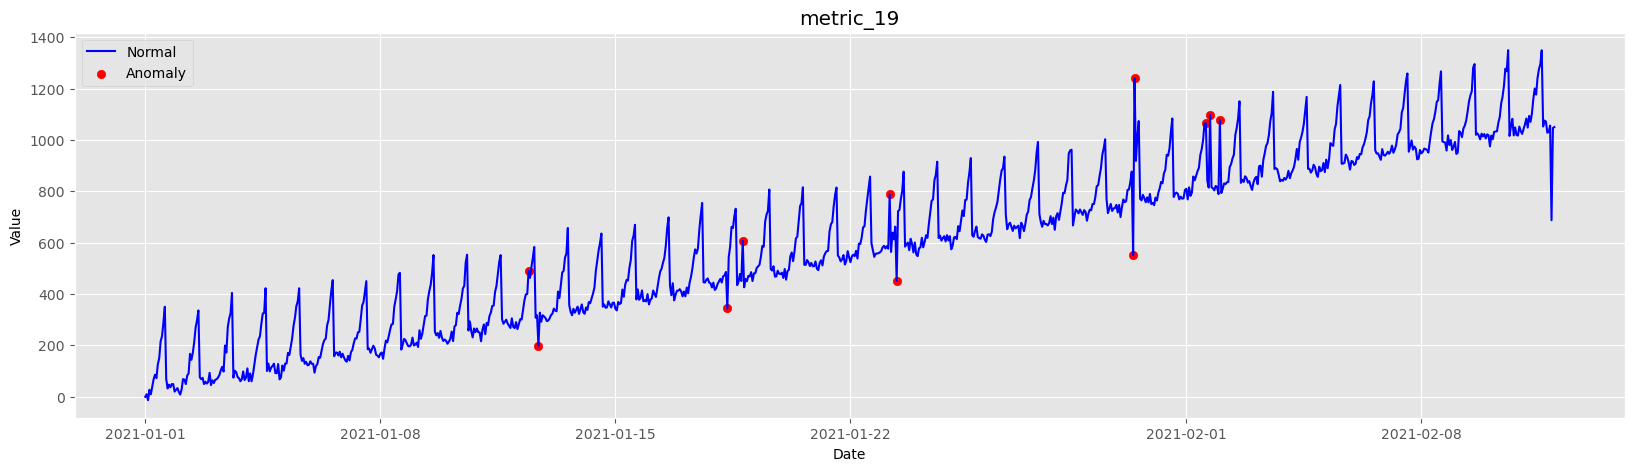

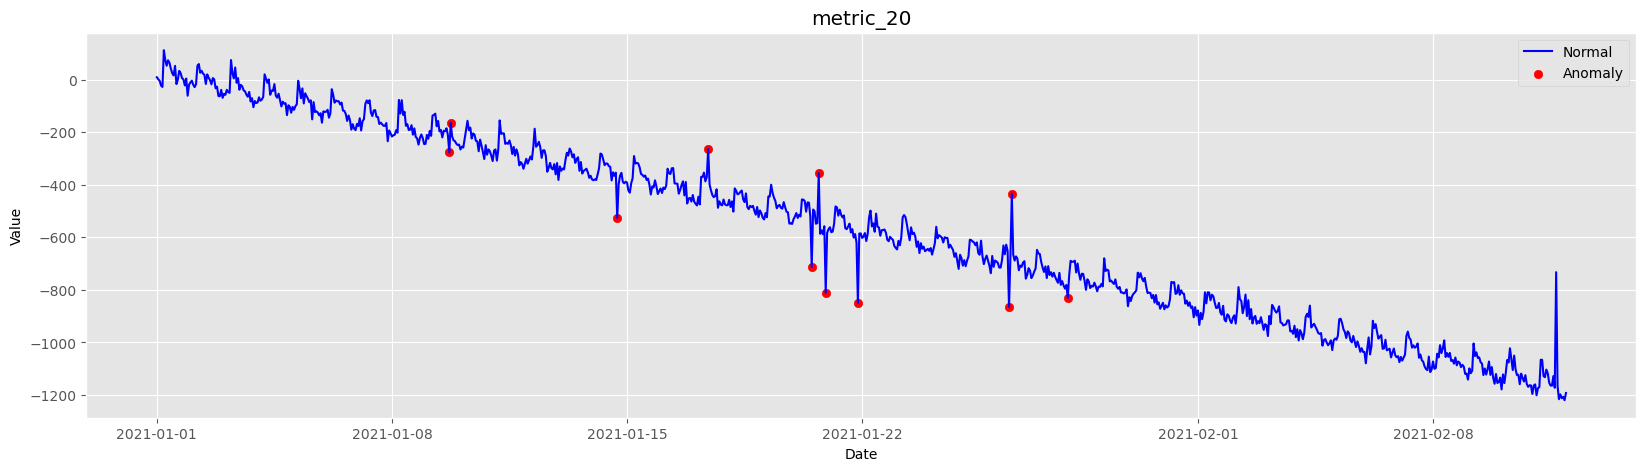

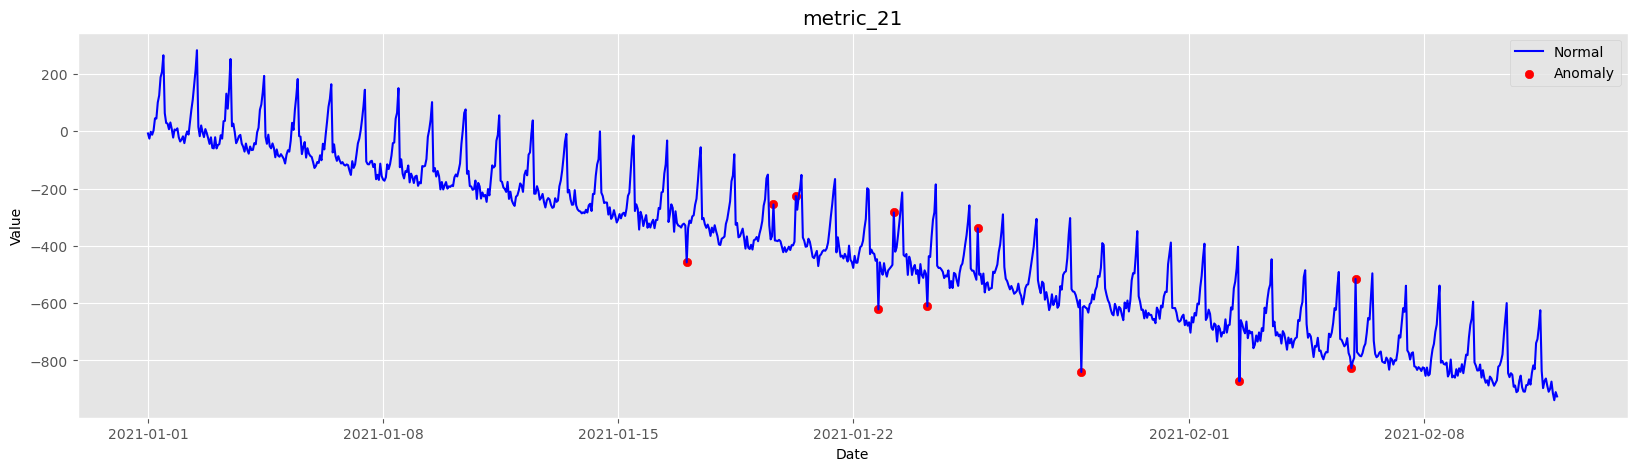

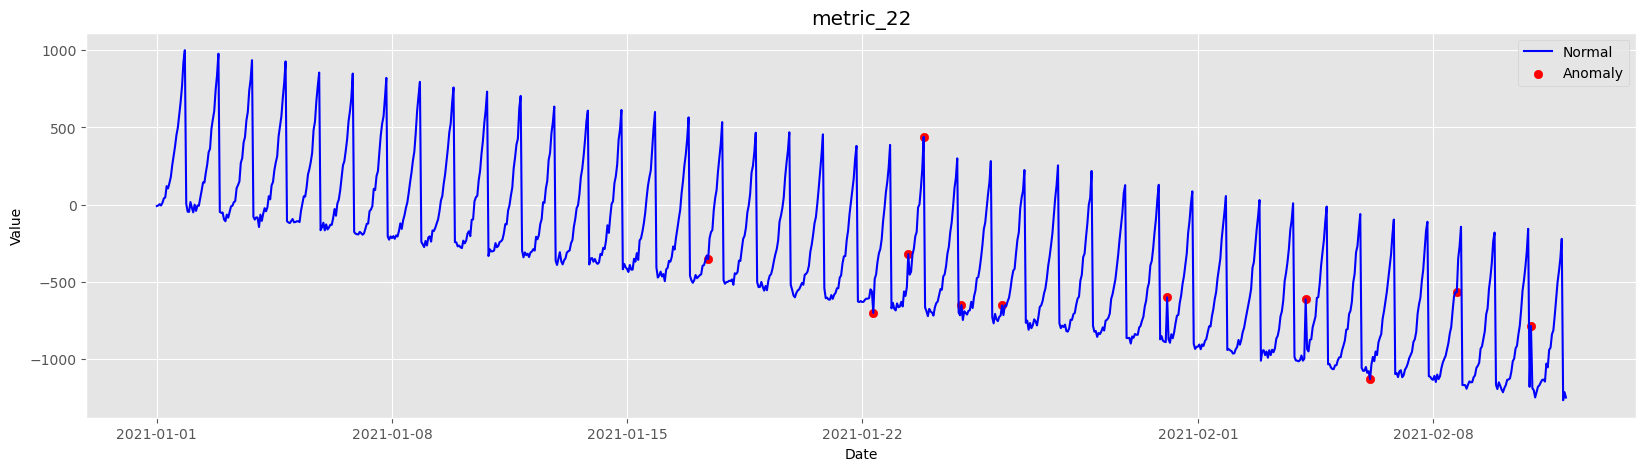

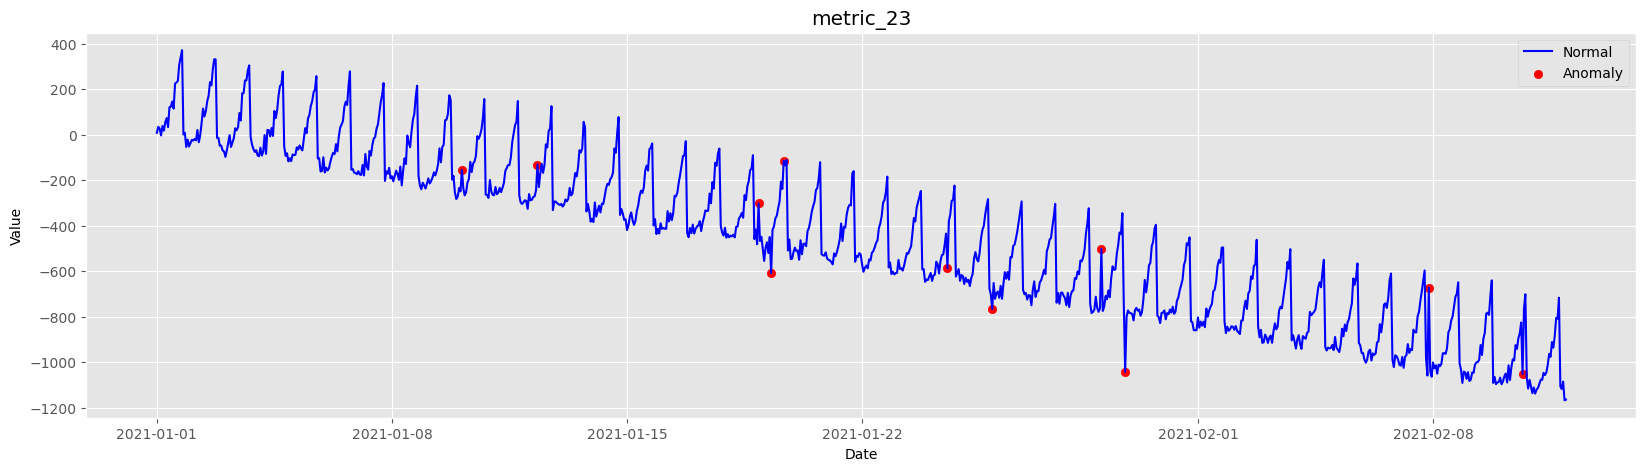

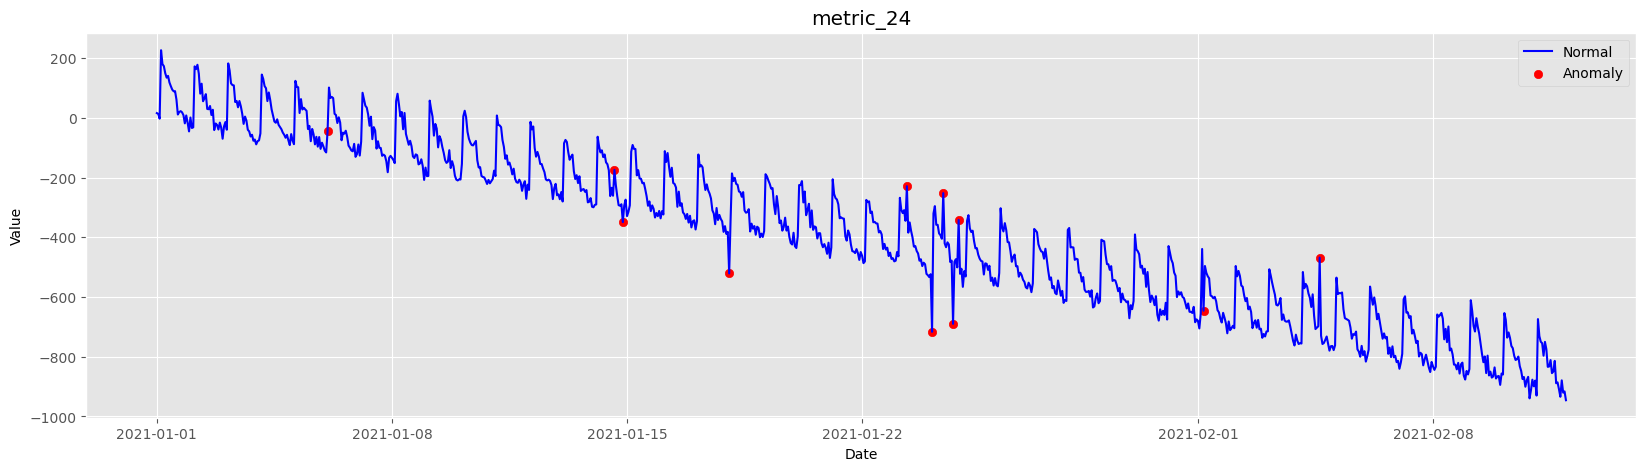

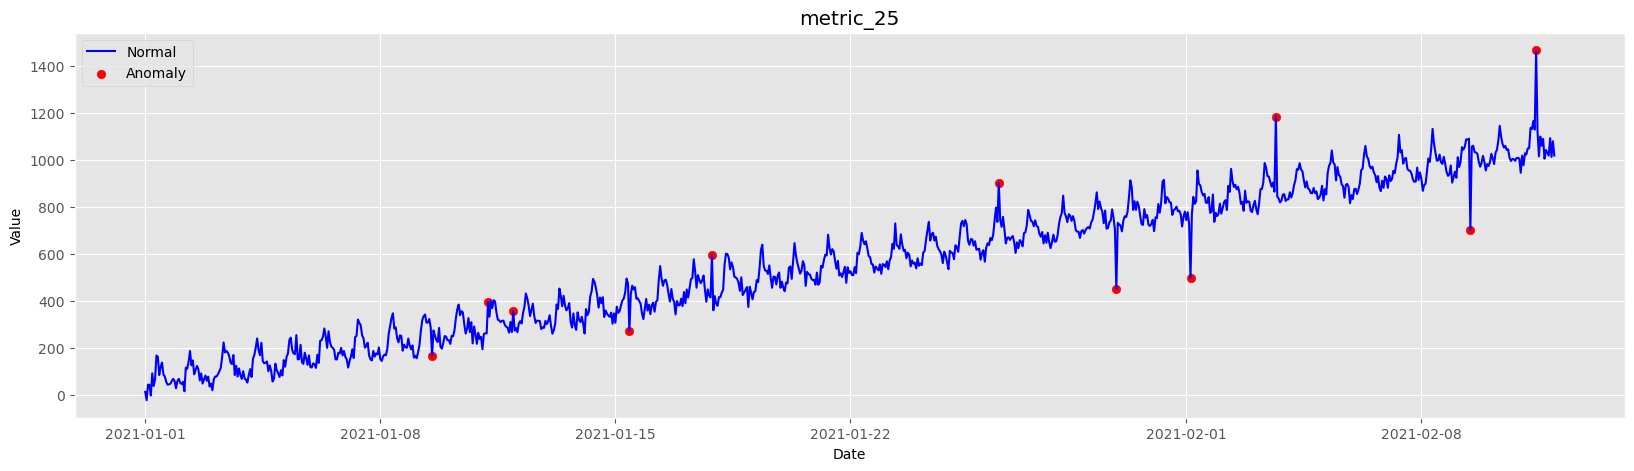

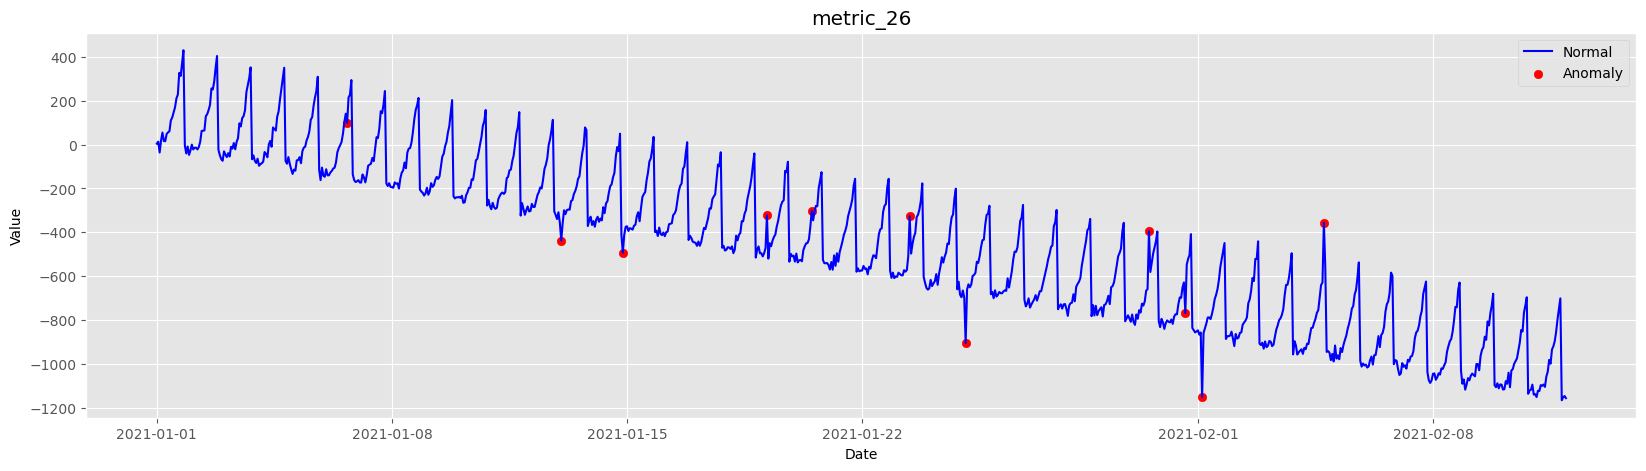

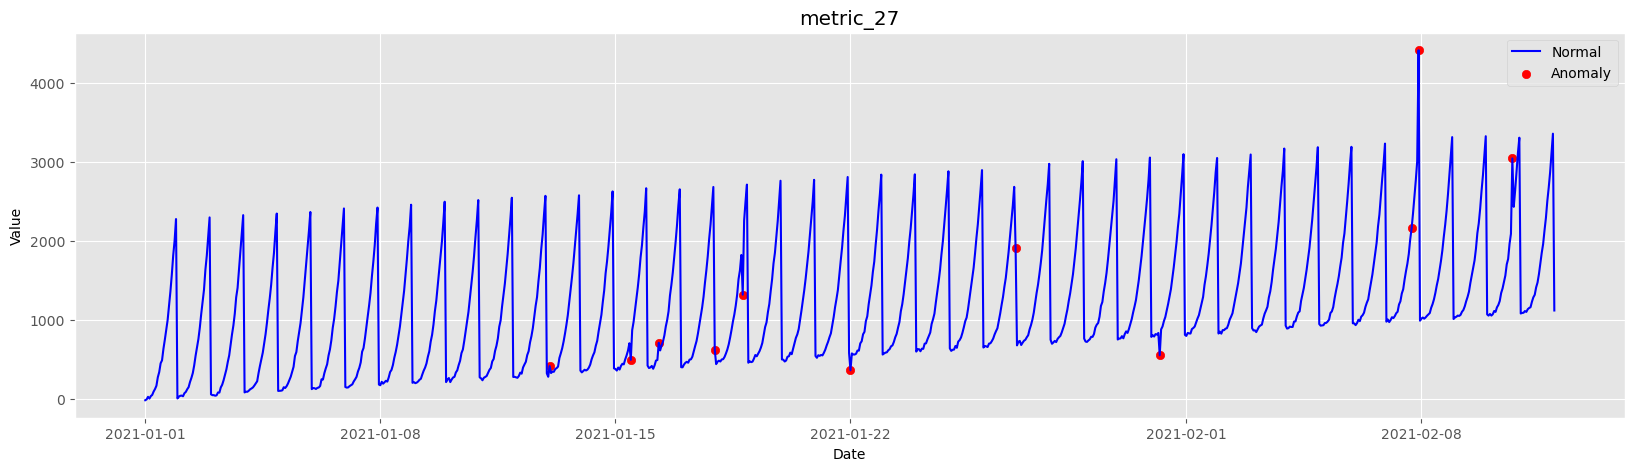

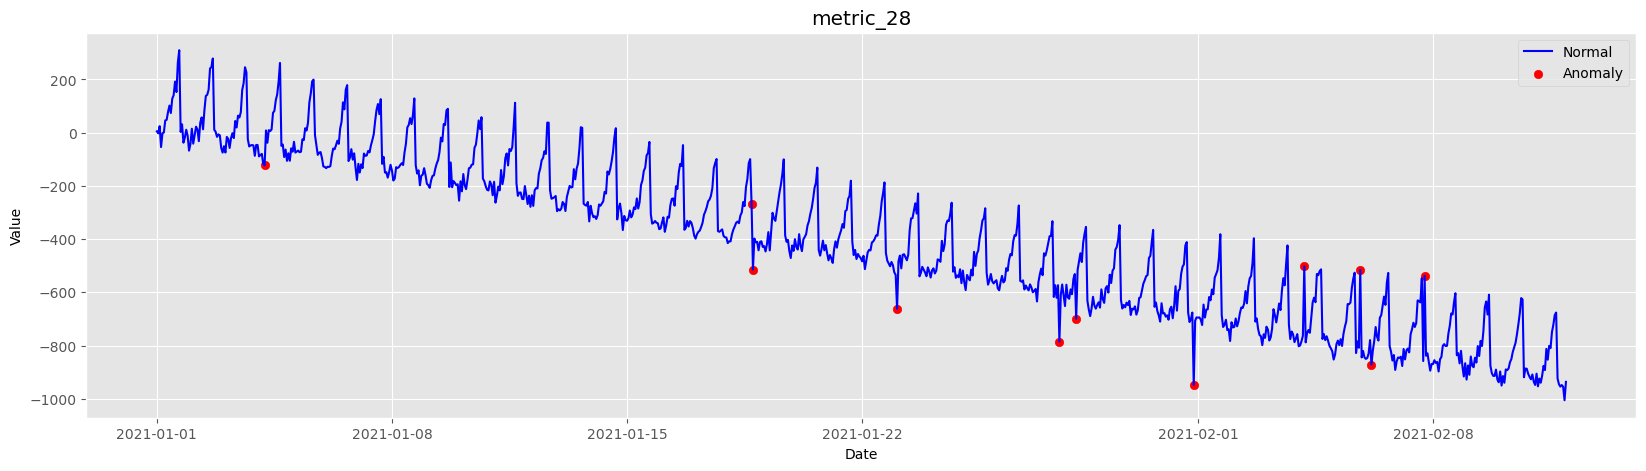

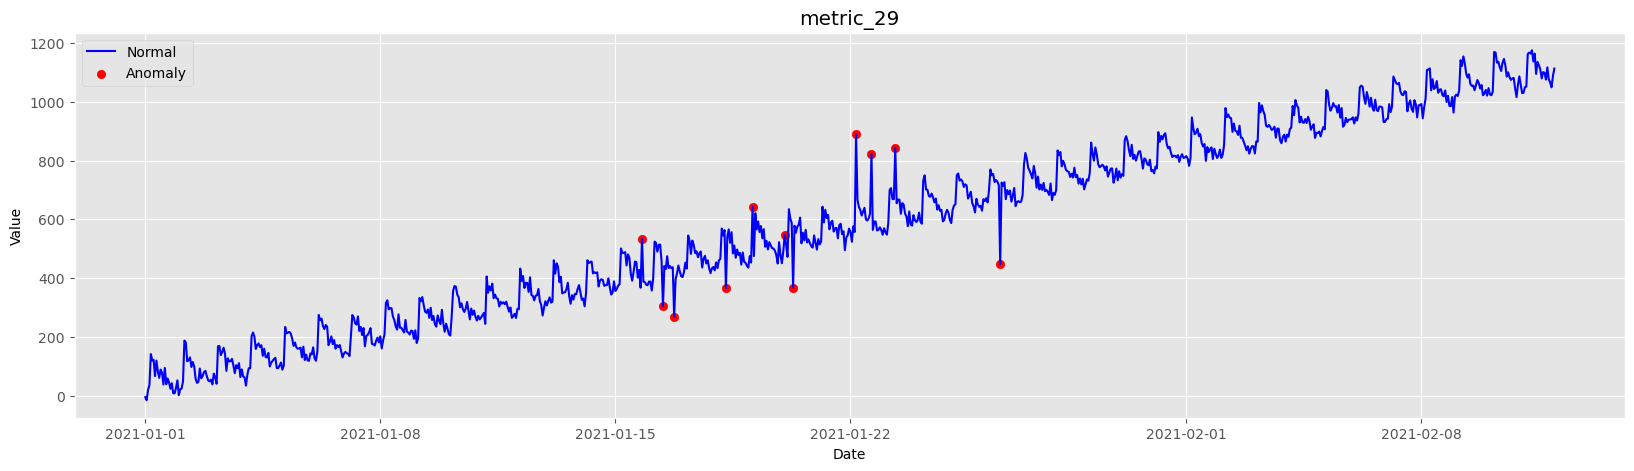

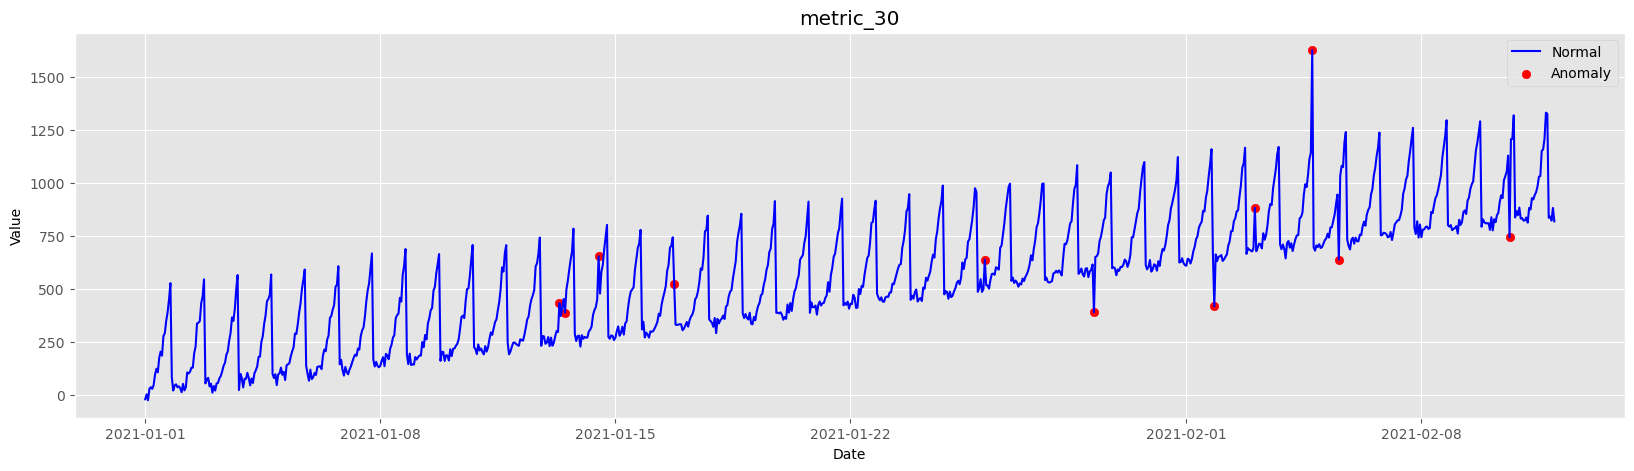

In [6]:
for col in df.columns:
    # apply STL decomposition
    res = sm.tsa.seasonal_decompose(df[col])
    residuals = pd.DataFrame({'residuals': res.resid}, index=data.index)
    
    
    # calculate  IQR
    q1 = residuals['residuals'].quantile(0.25)
    q3 = residuals['residuals'].quantile(0.75)
    iqr = q3 - q1
    
    # calculate upper and lower bounds based on the rolling IQR
    lower_bound = (q1 - 0.55 * iqr)
    upper_bound = (q3 + 0.55 * iqr)
    
    # find anomalies
    anomalies = residuals[(residuals['residuals'] < lower_bound) | (residuals['residuals'] > upper_bound)]
    anomalies['anomaly_diff']  = abs(anomalies['residuals'].sub(upper_bound).where(anomalies['residuals'] > upper_bound,
                                                                    other=anomalies['residuals'].sub(lower_bound)))
    
    top_n = int(np.ceil(len(data) * 1 / 100))
    top_n_outliers = anomalies.sort_values(by='anomaly_diff', ascending=False).head(top_n)
    
    # plot results
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(df.index, df[col], color='blue', label='Normal')
    ax.scatter(top_n_outliers.index, df.loc[top_n_outliers.index, col], color='red', label='Anomaly')
    plt.title(col)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    
    #saving plots
    plt.savefig(col + '_rolling_iqr_plot.png')
    
    plt.show()
